In [2]:
import pandas as pd
import os
import IPython.display as ipd
import matplotlib.pyplot as plt
import librosa
import librosa.display
import numpy as np
from tqdm import tqdm
import random
import sklearn
import pickle

# The world's simplest instrument classifier, using Constant-Q Transform and Logistic Regression.

All these samples were taken from University of Iowa Electronic Music Studios: http://theremin.music.uiowa.edu/MIS.html

The samples includes:
- Alto Saxophone, without vibrato
- Soprano Saxophone, without vibrato (Soprano sounds higher than Alto)
- Flute, without vibrato
- Horn (Trompa)
- Marimba, played with rubber, chord and yarn mallet, some of them with deadstroke.
- Bell, played with plastic and brass mallet
- Violin, with arco and pizzicato (from the samples I heard, without vibrato, but not explicit in their website)
- Viola, with arco and pizzicato (same condition as Violin)

### 0. Project structure:

- simple_classifier.ipynb: this very self Jupyter Notebook
- audios/: contains the data downloaded from the website above. The split/ folder will be generated programatically down below.
- audios/split: contains one second duration samples from the original recordings.
- audio_samples.dictionary and spectrogram_samples.dictionary: both will be generated programatically down below. Since it takes minutes to compute all the CQTs, it will be useful to save them locally, avoiding unnecessary computing time.

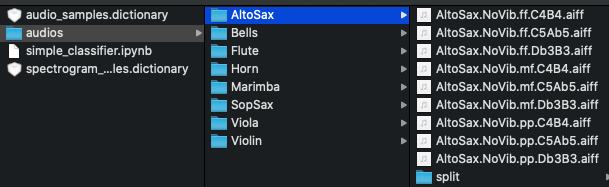

## 1. Pre-processing: Slicing all instrument recordings to one second duration samples.

In [3]:
# returns a key-pair value associated to each original recording, like {recording file name: instrument name}.
def get_dict():
    my_dict = dict()
    mypath = 'audios/'
    folders = [f for f in os.listdir(mypath) if os.path.isdir(os.path.join(mypath, f))]
    for folder in folders:
        files = [f for f in os.listdir(mypath+folder) if os.path.isfile(os.path.join(mypath+folder, f))]
        for file in files:
            my_dict.update({file:folder})
    return my_dict

#writes 1 second slices from all files, which where passed as a dict
#the slicing is done using sox - sound exchange: http://sox.sourceforge.net
#installing sox at linux: sudo apt-get install sox
#installing sox at macos: brew install sox
#this function calls a osx routine in the terminal, to split the original recordings.
def slice_audios(data_dict: dict):
    instruments = list(set(data_dict.values()))
    for instrument in tqdm(instruments):
        os.makedirs(os.path.join('audios', instrument, 'split'))
        os.system("cd "+os.path.join('audios', instrument)+" && find . -name '*.aiff'  -exec sh -c 'mkdir -p split/$(dirname \"{}\")' \;  -exec sox {} split/{}  trim 0 1 : newfile : restart \;")
        os.system("cd "+os.path.join('audios', instrument)+" && find . -name '*.aif'  -exec sh -c 'mkdir -p split/$(dirname \"{}\")' \;  -exec sox {} split/{}  trim 0 1 : newfile : restart \;")
        os.system("cd "+os.path.join('audios', instrument)+" && find . -name '*.mono'  -exec sh -c 'mkdir -p split/$(dirname \"{}\")' \;  -exec sox {} split/{}  trim 0 1 : newfile : restart \;")

        
#this function reads all the slices from the system
#it returns all these slices as a dict {sliced file name: instrument name}.
def get_sliced_dict():
    my_dict = dict()
    mypath = 'audios'
    folders = [f for f in os.listdir(mypath) if os.path.isdir(os.path.join(mypath, f))]
    for folder in folders:
        files = [f for f in os.listdir(os.path.join(mypath,folder,'split')) if os.path.isfile(os.path.join(os.path.join(mypath,folder,'split'), f))]
        for file in files:
            my_dict.update({file:folder}) #folders are homonyms with instruments. ex: violin/, marimba/, etc...
    return my_dict


In [4]:
slice_audios(get_dict())
print('We got', len(get_sliced_dict()), 'audio slices.')

We got 6185 audio slices.


## 2. Pre-processing: CQT spectrogram functions. We'll use them later.

The Constant-Q Transform (CQT) is like a Discrete Short-Time Fourier Transform (STFT), but streching the gaps between the lower frequencies, and shrinking the gaps between the higher frequencies. It will give us a better resolution for the first harmonics.

About STFT: https://www.audiolabs-erlangen.de/resources/MIR/FMP/C2/C2_STFT-Basic.html

About CQT: https://en.wikipedia.org/wiki/Constant-Q_transform

In [5]:
Fs = 44100/2

#returns a single tuple {sliced audio file name: sliced audio CQT}
def get_spectrogram_tuple(t: tuple, Fs):
#     print('tuple ->', t)
    path = os.path.join('audios', t[1], 'split', t[0])
#     print('path ->', path)
    y, Fs = librosa.load(path, sr=Fs)
    return {t[0]: np.abs(librosa.cqt(y))}
    
#returns a complete dict {sliced audio file name: sliced audio CQT}
def get_spectrogram_dict(data_dict: dict, Fs: int):
    spect_dict = dict()
    for file in tqdm(data_dict.items()):
#         print('file ->', file)
        try:
            t = get_spectrogram_tuple(file, Fs)
            spect_dict.update(t)
        except librosa.util.exceptions.ParameterError:
            pass
    return spect_dict

### Some (tricky) examples to identify:

In [6]:
print('Instrumentos, não necessariamente nessa ordem, podendo haver mais de uma amostra do mesmo:\nTrompa, sino, flauta, violino, viola, sax soprano, sax alto, marimba.')
#1
ipd.display(ipd.Audio(os.path.join('audios','AltoSax','split','AltoSax.NoVib.mf.C5Ab5019.aiff'), rate=44100))
#2
ipd.display(ipd.Audio(os.path.join('audios','Flute','split','flute.nonvib.pp.C6Bb6016.aiff'), rate=44100))
#3
ipd.display(ipd.Audio(os.path.join('audios','Violin','split','Violin.pizz.ff.sulA.C6A6.mono032.aif'), rate=44100))
#4
ipd.display(ipd.Audio(os.path.join('audios','Marimba','split','Marimba.yarn.ff.Bb4.stereo001.aif'), rate=44100))
#5
ipd.display(ipd.Audio(os.path.join('audios','Horn','split','Horn.mf.C5F5010.aiff'), rate=44100))
#6
ipd.display(ipd.Audio(os.path.join('audios','AltoSax','split','AltoSax.NoVib.mf.C5Ab5014.aiff'), rate=44100))
#7
ipd.display(ipd.Audio(os.path.join('audios','Horn','split','Horn.ff.C3B3028.aiff'), rate=44100))
#8
ipd.display(ipd.Audio(os.path.join('audios','Bells','split','bells.brass.ff.Eb5.stereo003.aif'), rate=44100))
#9
ipd.display(ipd.Audio(os.path.join('audios','SopSax','split','SopSax.nonvib.ff.Gb5.stereo003.aif'), rate=44100))
#10
ipd.display(ipd.Audio(os.path.join('audios','Viola','split','Viola.pizz.ff.sulD.C5.stereo002.aif'), rate=44100))

Instrumentos, não necessariamente nessa ordem, podendo haver mais de uma amostra do mesmo:
Trompa, sino, flauta, violino, viola, sax soprano, sax alto, marimba.


Palpite médio, nessa ordem: (inserir palpites aqui)
1- 2- 3- 4- 5- 6- 7- 8- 9- 10-

### Takes a random sample and plot it's CQT, or takes from a selected sample. You may notice there are various silence samples.

Text(0.5, 1.0, 'sample = Horn.ff.C3B3028.aiff, matrix size = (84, 44)')

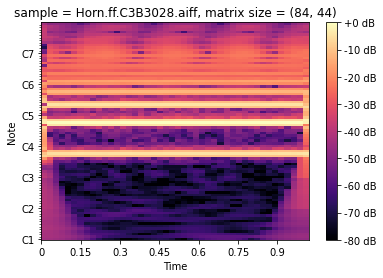

In [7]:
%matplotlib inline
t = random.choice(list(get_sliced_dict().items()))
#t = ('Horn.ff.C3B3028.aiff', 'Horn')

ipd.display(ipd.Audio(os.path.join('audios',t[1],'split',t[0]), rate=44100))
d = get_spectrogram_tuple(t, Fs)
sample_name, C = list(d.items())[0]
librosa.display.specshow(librosa.amplitude_to_db(C, ref=np.max),sr=Fs, x_axis='time', y_axis='cqt_note')
plt.colorbar(format='%+2.0f dB')
plt.title('sample = ' + sample_name + ', matrix size = ' + str(C.shape))

### Generates a CQT for each one of the 4553 samples,
### assign the CQTs in a python dict, associated with their samples file names,
### and then saves locally as a file. Takes a while to process...

In [8]:
spect_dict = get_spectrogram_dict(get_sliced_dict(), Fs)

with open('spectrogram_samples.dictionary', 'wb') as dictionary_file:
      pickle.dump(spect_dict, dictionary_file)

### Since we saved locally the CQTs, we retrieve them by reading them from the system. Time saving.

In [9]:
with open('spectrogram_samples.dictionary', 'rb') as dictionary_file:
     spect_dict_new = pickle.load(dictionary_file)

In [13]:
spect_dict
print('before ->',len(spect_dict))
print('after ->', len(spect_dict_new))

before -> 6184
after -> 6184


### Since each 'pixel' from the CQT will be a weight in our classifier, we vectorize our m x n matrices as a (m * n) x 1 column vector.

### Hot fix: some samples do not have 1 second. In a 5.2 seconds audio, we have splited before in five samples with 1 second, and one sample with 0.2 seconds. Here we make sure our training and test sets have the same dimensions.

In [14]:
from sklearn.preprocessing import StandardScaler

spect_dict = spect_dict_new
instrument_dict = get_sliced_dict()
X_list = list()
Y_list = list()
for k in spect_dict:
    X_list.append(spect_dict[k])
    Y_list.append(instrument_dict[k])
        
X = []
Y = []
for i in range(len(X_list)):
    if X_list[i].shape == (84,44):
        X.append(X_list[i])
        Y.append(Y_list[i])

X = np.dstack(X).T
X = X.reshape(X.shape[0],-1)

#We can normalize each feature (in this case, the pixel at the same position for all samples)
# pixel_normalized = (pixel - mean)/standard_deviation
#since all of them have a close mean and standard_deviation,
#it will not be a huge problem when minimizing the error.
scaler = StandardScaler()
X = scaler.fit_transform(X)

Y = np.array(Y).reshape(1, -1).T

# Y = sklearn.preprocessing.label_binarize(Y, classes = [0,1,2,3,4,5])
# n_classes = Y_a.shape[1]

In [15]:
print(X.shape)
print(Y.shape)

(5525, 3696)
(5525, 1)


In [16]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, Y, test_size=0.2, random_state=42)
print('full size ->',len(X),'\ntest size ->', len(Y))
print('train size ->',len(X_train),'\ntest size ->', len(y_train))
print('test size ->',len(X_test),'\ntest size ->', len(y_test))

full size -> 5525 
test size -> 5525
train size -> 4420 
test size -> 4420
test size -> 1105 
test size -> 1105


## 3. Training our classifier.

In [17]:
from sklearn.linear_model import LogisticRegression
lr_ovr = LogisticRegression(max_iter=3200)
lr_ovr.fit(X_train, y_train.ravel())

y_pred = lr_ovr.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(lr_ovr.score(X_test, y_test.ravel())))

Accuracy of logistic regression classifier on test set: 0.80


In [18]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

     AltoSax       0.64      0.52      0.57        95
       Bells       0.74      0.60      0.66       131
       Flute       0.66      0.68      0.67        59
        Horn       0.87      0.80      0.83        59
     Marimba       0.86      0.74      0.79        42
      SopSax       0.33      0.58      0.42        12
       Viola       0.74      0.62      0.68        96
      Violin       0.85      0.93      0.89       611

    accuracy                           0.80      1105
   macro avg       0.71      0.68      0.69      1105
weighted avg       0.79      0.80      0.79      1105



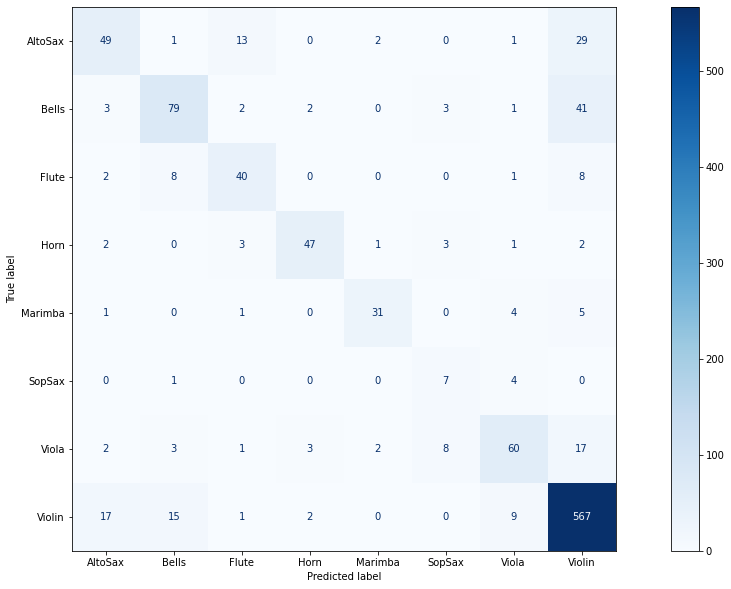

In [24]:
from sklearn.metrics import plot_confusion_matrix
disp = plot_confusion_matrix(lr_ovr, X_test, y_test, cmap=plt.cm.Blues)
plt.rcParams['figure.figsize'] = [20, 10]
plt.show()

#### The accuracy of the classifier went high mainly because it's working well on true positives for violins, and also there are more violin samples than any of the instruments in the dataset.

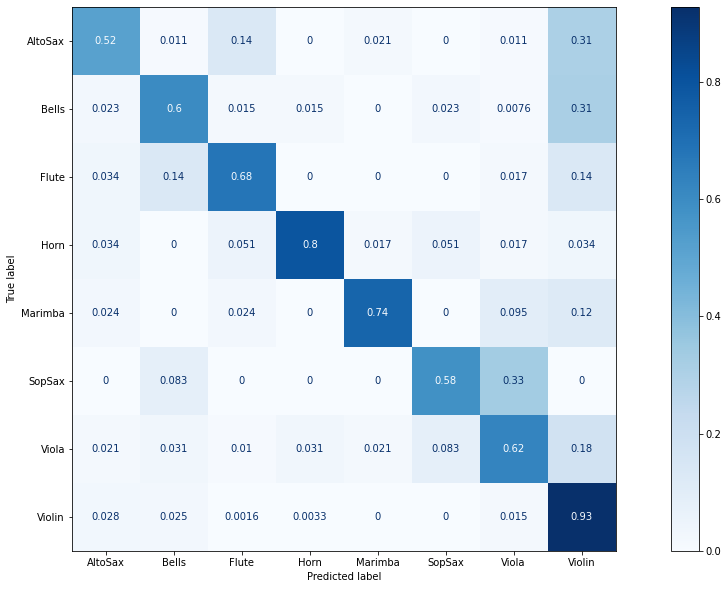

In [20]:
disp = plot_confusion_matrix(lr_ovr, X_test, y_test, cmap=plt.cm.Blues, normalize='true')
plt.rcParams['figure.figsize'] = [20, 10]
plt.show()

### 4. Checking values function.

In [21]:
#show the sample audio player, CQT and asks the prediction to the trained classifier
#returns true if prediction matches ground value
def play_display_and_predict():
    t = random.choice(list(get_sliced_dict().items()))
    d = get_spectrogram_tuple(t, Fs)
    sample_name, C = list(d.items())[0]
    prediction = lr_ovr.predict(C.reshape(1,-1))
    result = (t[1] == prediction[0])
    audio_player = ipd.Audio(os.path.join('audios',t[1],'split',t[0]), rate=44100)
    return result, audio_player, C, sample_name, t[1], prediction[0]

### Show a random wrong prediction.

predicted Violin as Flute


Text(0.5, 1.0, 'sample = Violin.arco.pp.sulG.C5G5.mono051.aif, matrix size = (84, 44)')

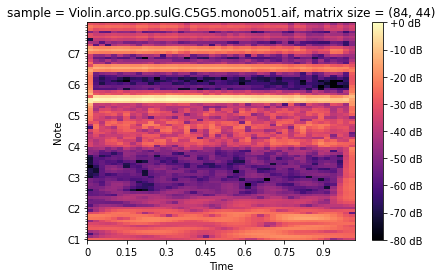

In [22]:
%matplotlib inline

i = True
while i == True:
    try: result, audio_player, C, sample_name, instrument, prediction = play_display_and_predict()
    except ValueError: pass
    i = result
print('predicted', instrument,'as',prediction)
ipd.display(audio_player)
librosa.display.specshow(librosa.amplitude_to_db(C, ref=np.max),sr=Fs, x_axis='time', y_axis='cqt_note')
plt.colorbar(format='%+2.0f dB')
plt.title('sample = ' + sample_name + ', matrix size = ' + str(C.shape))

next steps: how to handle those silence samples? Also, there are few samples in most of the instruments, except the violin.

That's all, folks.